In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import seaborn as sns
import pandas as pd
from environment.TheoreticalMarket import *


In [3]:
filename = "sim_results/market-marl-nash-3-05-02-2022-20-08-0540_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)


In [4]:
res.marl_params

{'epochs': 40,
 'explore_epsilon': 0.05,
 'max_steps': 30,
 'sync_freq': 20,
 'mem_size': 101333,
 'turbo_max_evals': 5,
 'turbo_batch_size': 5,
 'turbo_n_init': 5,
 'batch_size': 10}

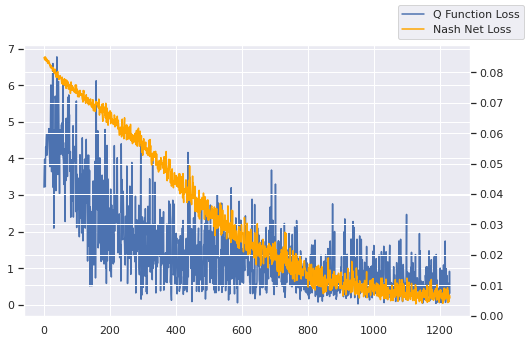

In [5]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="orange")

# data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="red")
ax.figure.legend()


In [6]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)

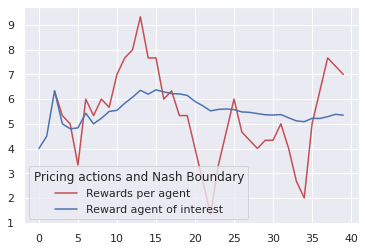

In [7]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

all_rewards = res.episode_rewards
agent_ind = 0
x = res.episode_rewards[:, -1, agent_ind]
smoothed_episode_rewards = moving_average(x)

# episode rewards all agents

sns.set()
x = np.arange(len(all_rewards))

# plt.plot(x, avg_ag_actions, 'b-', label='Average Agent Price')
# plt.plot(x, ref_prices, 'r--', label='Ref. Price')
plt.plot(x[2:], smoothed_episode_rewards, 'r', label='Rewards per agent')
plt.plot(x, res.avg_epoch_rewards_agent, 'b', label='Reward agent of interest')


plt.legend(title='Pricing actions and Nash Boundary')
plt.show()

<AxesSubplot:>

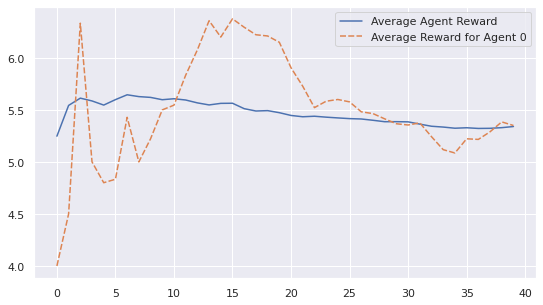

In [8]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [9]:


# Theoretical Data
# tm = TheoreticalMarket(beta0 = 30, beta1 = -1.1, beta2 = -2, a = 0.1, ref_p = 1.5)
beta0 = 25
beta1 = -0.9
beta2 = -1.1
a = 0.1

# Market 2
# beta0 = 25
# beta1 = -0.6
# beta2 = -6.1
# a = 0.1

# Market 3
# beta0 = 15
# beta1 = -1.05
# beta2 = -3.1
# a = 0.1

# Config 4
# beta0 = 13
# beta1 = -5.05
# beta2 = -2.1
# a = 0.2

# Config 5
# beta0 = 27
# beta1 = -3.05
# beta2 = -1.1
# a = 0.2



# Simulation Data
ep = 31
# ref_prices = res.state_tracker_epoch[ep]
ref_prices = res.state_tracker[ep]

episode_rewards = res.episode_rewards[ep]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[ep]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

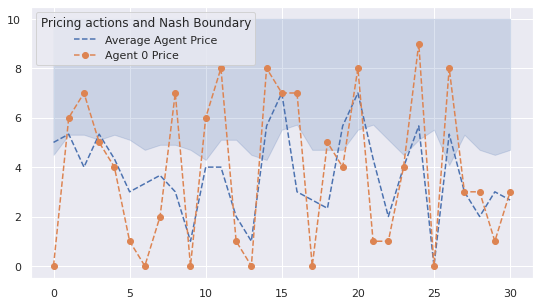

In [10]:

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

# min_eps_price, max_eps_price = get_eps0_range(9.9, Y, X, z)

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

# Episode rewards 

avg_ag_rewards = episode_rewards.mean(axis = 1)
avg_ag_actions= episode_joint_actions.mean(axis = 1)
agent_interest_action = episode_joint_actions[:, 1]

sns.set()
x = np.arange(len(avg_ag_actions))

plt.plot(x, avg_ag_actions, '--', label='Average Agent Price')
# plt.plot(x, ref_prices, 'r--', label='Ref. Price')
# plt.plot(x, avg_ag_rewards, 'r--', label='Ref. Price')
plt.plot(x, agent_interest_action, 'o--', label='Agent 0 Price')



plt.fill_between(x, nash_upper_bound, nash_lower_bound, color='b', alpha=0.2)


plt.legend(title='Pricing actions and Nash Boundary')
plt.show()

In [11]:
from scipy.ndimage.interpolation import shift

computed_ref_price = np.mean(res.episode_actions[:,-1, :], axis =1)
computed_avg_action = shift(computed_ref_price, -1, cval=computed_ref_price[-1])
computed_ref_price_pair = np.array([computed_ref_price, computed_avg_action]).T


/tmp/ipykernel_59635/836626244.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [12]:
nash_eps_bounds_all_ep = [get_eps0_range(ref_price, Y, X, z) for ref_price in computed_ref_price]

nash_lower_bound_all_ep =  [v[0] for v in nash_eps_bounds_all_ep]
nash_upper_bound_all_ep =  [v[1] for v in nash_eps_bounds_all_ep]

In [13]:
import copy

def est_revenue_from_refprice(crp):
    demand = beta0 + beta1*crp[1] + beta2*(crp[1] - crp[0])
    return demand * crp[1]

nash_lower_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_upper_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_lower_bound_ref_pair[:, 1] = nash_lower_bound_all_ep
nash_upper_bound_ref_pair[:, 1] = nash_upper_bound_all_ep
nash_lower_bound_all_rev_ep =  [est_revenue_from_refprice(v)/3 for v in nash_lower_bound_ref_pair]
nash_upper_bound_all_rev_ep =  [est_revenue_from_refprice(v)/3 for v in nash_upper_bound_ref_pair]

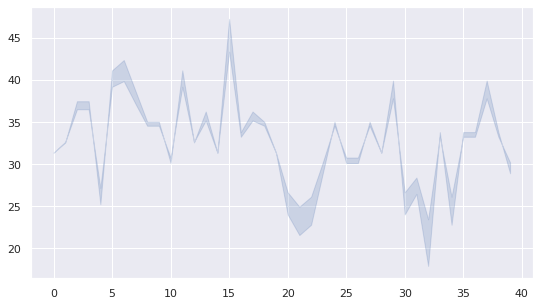

In [14]:
sns.set()
x = np.arange(len(nash_lower_bound_all_ep))

plt.fill_between(x, nash_lower_bound_all_rev_ep, nash_upper_bound_all_rev_ep, color='b', alpha=0.2)

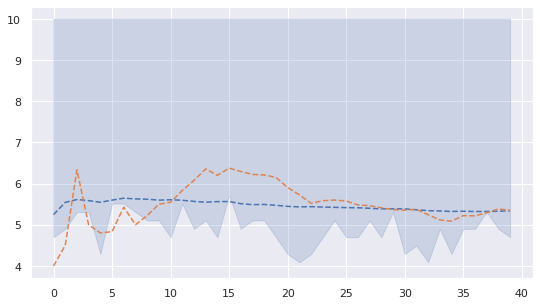

In [15]:




sns.set()
x = np.arange(len(nash_lower_bound_all_ep))

plt.plot(x, res.avg_epoch_rewards, '--', label='Average Episode Rewards')
plt.plot(x, res.avg_epoch_rewards_agent, '--', label='Reward Agent 0')
# plt.plot(x, ref_prices, 'r--', label='Ref. Price')
# plt.plot(x, avg_ag_rewards, 'r--', label='Ref. Price')
# plt.plot(x, agent_interest_action, 'o--', label='Agent 0 Price')

plt.fill_between(x, nash_lower_bound_all_ep, nash_upper_bound_all_ep, color='b', alpha=0.2)


In [16]:
# When the solid blue line in inside the fill, there is no incentive to deviate, otherwise, there is incentive, and the agents should try to undercut.

<AxesSubplot:>

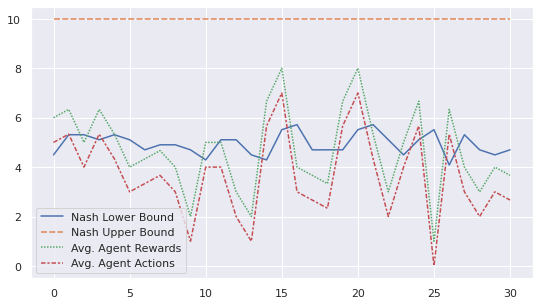

In [17]:
# "Ref Prices": ref_prices, 
nash_bound_per_run = {"Nash Lower Bound": nash_lower_bound, 
    "Nash Upper Bound": nash_upper_bound, 
    "Avg. Agent Rewards": avg_ag_rewards, 
    "Avg. Agent Actions": avg_ag_actions}
nash_bound_per_run_df = pd.DataFrame(data=nash_bound_per_run)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=nash_bound_per_run_df)

In [18]:
nash_bound_per_run_df

,Nash Lower Bound,Nash Upper Bound,Avg. Agent Rewards,Avg. Agent Actions
0,4.495306,10.0,6.000000,5.000000
1,5.310816,10.0,6.333333,5.333333
2,5.310816,10.0,5.000000,4.000000
3,5.106939,10.0,6.333333,5.333333
4,5.310816,10.0,5.333333,4.333333
5,5.106939,10.0,4.000000,3.000000
6,4.699184,10.0,4.333333,3.333333
7,4.903061,10.0,4.666667,3.666667
8,4.903061,10.0,4.000000,3.000000
9,4.699184,10.0,2.000000,1.000000


In [19]:
res.episode_rewards[0]

array([[10.,  6.,  8.],
       [ 1.,  8.,  3.],
       [ 1.,  7.,  3.],
       [ 2.,  6.,  2.],
       [10.,  7.,  6.],
       [ 1.,  5.,  2.],
       [ 2.,  5.,  2.],
       [ 7.,  6.,  6.],
       [ 5.,  3.,  6.],
       [ 1.,  2.,  2.],
       [ 7., 10.,  9.],
       [ 6.,  8.,  8.],
       [ 1.,  9.,  3.],
       [ 8.,  3.,  6.],
       [ 5.,  8., 10.],
       [ 3.,  2.,  4.],
       [ 8.,  8.,  2.],
       [ 6., 10.,  9.],
       [ 8.,  4.,  2.],
       [ 6.,  2.,  2.],
       [ 1.,  8.,  1.],
       [ 9.,  3.,  5.],
       [ 4., 10.,  7.],
       [ 6.,  8.,  8.],
       [ 1.,  1.,  6.],
       [ 9.,  8.,  2.],
       [ 1.,  9.,  4.],
       [10.,  9.,  1.],
       [ 8.,  6.,  5.],
       [ 1.,  9.,  1.],
       [ 4.,  4.,  7.]])

In [20]:
state_key = [0.0, 0.0, 0.0, 3.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [21]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.07715773634577232
0.12564030730176434
0.006258009004641955
0.08722380605749955
0.12427597338075264
0.06746017217181592
0.030431248799860585
0.34099359306376453
0.10213554163436932
0.03842361223975868
7


In [22]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1194406696176708
0.13311633668390876
0.014134491462107074
0.13208066191632606
0.06621798672649012
0.032727376374615195
0.15033492255737768
0.1821821620380229
0.031183942849879732
0.13858144977360173
7


In [23]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1600598925553418
0.11680299173103555
0.07487489839846645
0.1361299362778963
0.19097254702133806
0.10997900927535938
0.01941654985596047
0.06599295891661512
0.11231118706334375
0.013460028904643156
4
